In [1]:
# Import necessary libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
# Function to fetch data from the BANCO CENTRAL DO BRASIL API

def fetch_bcb_data(codigo_serie, data_inicio, data_fim):

    # Adjust the date range for daily series to a maximum of 5 years
    data_inicio_dt = datetime.strptime(data_inicio, '%d/%m/%Y')
    data_fim_dt = datetime.strptime(data_fim, '%d/%m/%Y')
    max_range = timedelta(days=365 * 5)

    all_data = []

    while data_inicio_dt <= data_fim_dt:

        # Calculate the end date for the current 5-year window
        current_end = min(data_inicio_dt + max_range, data_fim_dt)

        url = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo_serie}/dados"

        params = {
            'formato': 'json',
            'dataInicial': data_inicio_dt.strftime('%d/%m/%Y'),
            'dataFinal': current_end.strftime('%d/%m/%Y')
        }

        response = requests.get(url, params=params)

        if response.status_code == 200:
            data = response.json()
            all_data.extend(data)
        else:
            print(f"Erro na requisição: {response.status_code}")
            return None

        data_inicio_dt = current_end + timedelta(days=1)

    # Convert the collected data into a pandas DataFrame
    df = pd.DataFrame(all_data)
    df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y')
    df['valor'] = pd.to_numeric(df['valor'], errors='coerce')
    
    return df

In [3]:
# Index IPCA (code 12) from 1986 to today

df_CDI = fetch_bcb_data(12, "06/03/1986", datetime.now().date().strftime('%d/%m/%Y'))

display(df_CDI)

,data,valor
0,1986-03-06,0.068111
1,1986-03-10,0.069028
2,1986-03-12,0.067417
3,1986-03-14,0.064584
4,1986-03-17,0.068222
...,...,...
9786,2025-04-17,0.052531
9787,2025-04-22,0.052531
9788,2025-04-23,0.052531
9789,2025-04-24,0.052531


In [87]:
df_CDI_2020s = df_CDI.copy()

In [88]:
df_CDI_2020s = df_CDI_2020s[df_CDI_2020s['data'] >= '2020-01-01']

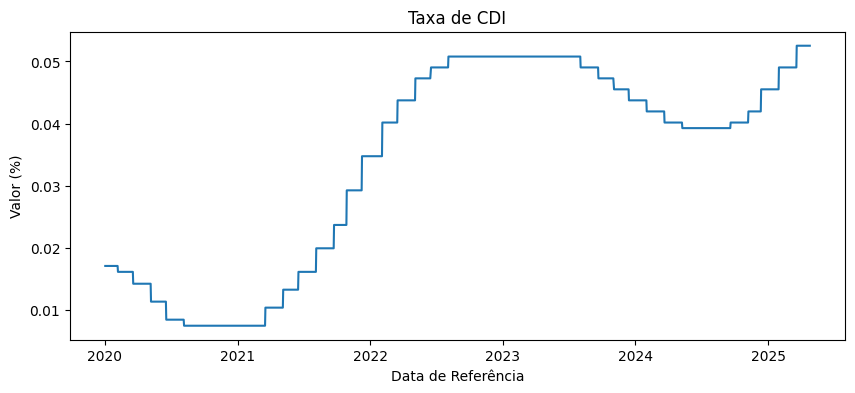

In [89]:
# Plot the values on specified dates
plt.figure(figsize=(10, 4))
plt.plot((df_CDI_2020s[df_CDI_2020s['data'] >= '2020-01-01'])['data'], 
         (df_CDI_2020s[df_CDI_2020s['data'] >= '2020-01-01'])['valor'], label='Rate')
plt.title('Taxa de CDI')
plt.xlabel('Data de Referência')
plt.ylabel('Valor (%)')
plt.grid(False)
plt.show()

In [90]:
# Calculate the accumulated return
df_CDI_2020s['Accumulated Return'] = (1 + df_CDI_2020s['valor'] / 100).cumprod()

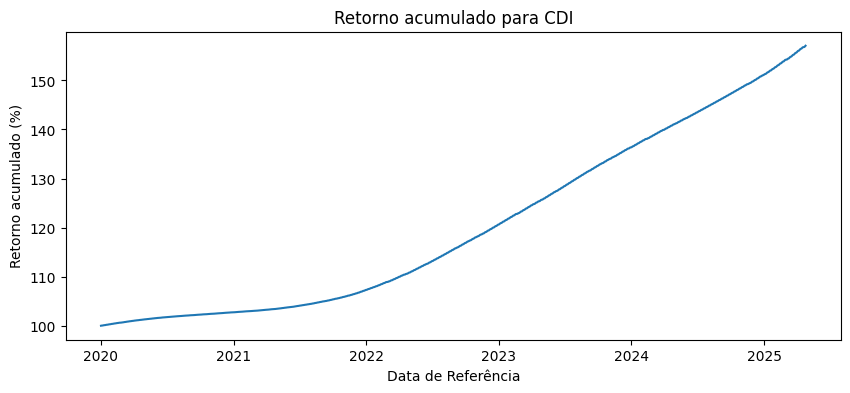

In [91]:
# Plot the accumulated return
plt.figure(figsize=(10, 4))
plt.plot((df_CDI_2020s[df_CDI_2020s['data'] >= '2020-01-01'])['data'], 
         (df_CDI_2020s[df_CDI_2020s['data'] >= '2020-01-01'])['Accumulated Return'] * 100, label='Accumulated Return')
plt.title('Retorno acumulado para CDI')
plt.xlabel('Data de Referência')
plt.ylabel('Retorno acumulado (%)')
plt.grid(False)
plt.show()

In [106]:
df_plot_mon_ret = df_CDI_2020s.copy()

In [107]:
# Get last value for each month
df_plot_mon_ret['year'] = df_plot_mon_ret['data'].dt.year
df_plot_mon_ret['month'] = df_plot_mon_ret['data'].dt.month

monthly_acc_linear = df_plot_mon_ret.groupby([df_plot_mon_ret['data'].dt.to_period('M')])['Accumulated Return'].last().reset_index()
monthly_acc_linear['data'] = monthly_acc_linear['data'].dt.to_timestamp()

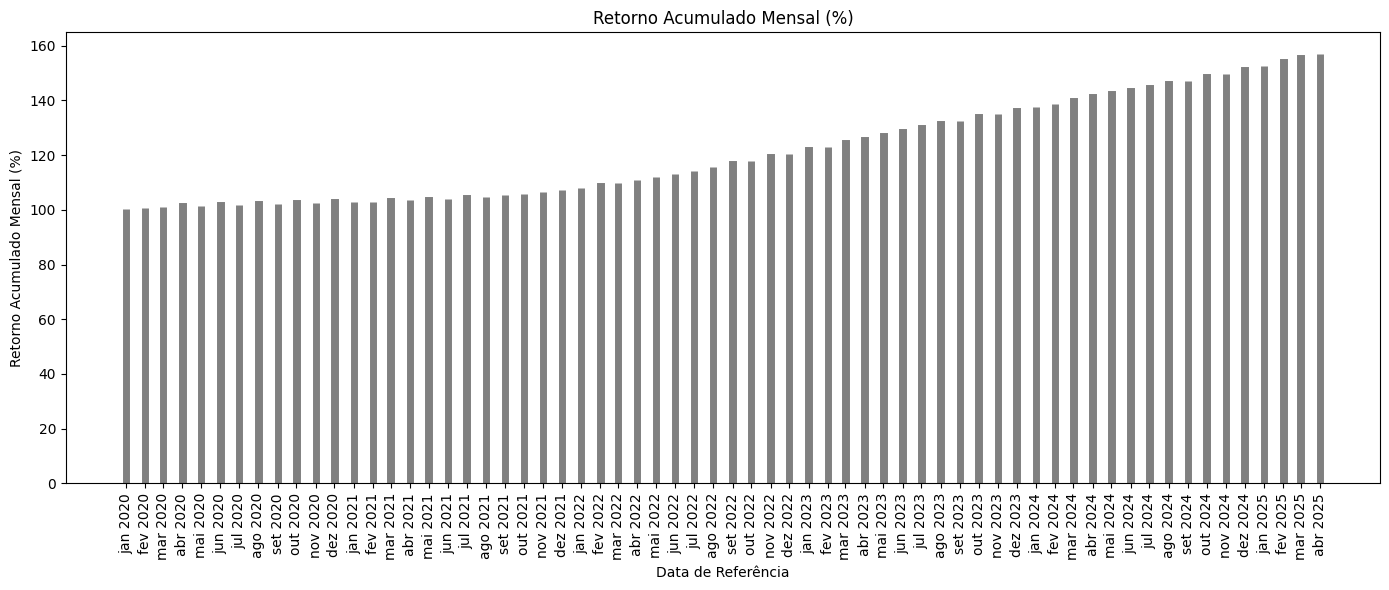

In [108]:
# Bold bars and show each month on the x-axis label
plt.figure(figsize=(14, 6))
bars = plt.bar(monthly_acc_linear['data'], monthly_acc_linear['Accumulated Return']*100, linewidth=5, edgecolor='gray')
plt.title('Retorno Acumulado Mensal (%)')
plt.xlabel('Data de Referência')
plt.ylabel('Retorno Acumulado Mensal (%)')
plt.xticks(monthly_acc_linear['data'], [d.strftime('%b %Y') for d in monthly_acc_linear['data']], rotation=90)
plt.tight_layout()
plt.show()
